In [ ]:
import zipfile

zip_path = "/content/twitter_training.csv.zip"
extract_to = "/content/unzipped_folder"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped successfully to:", extract_to)


Unzipped successfully to: /content/unzipped_folder


In [ ]:
import pandas as pd

df = pd.read_csv('/content/unzipped_folder/twitter_training.csv', header=None)

df = df[[3, 2]]
df.columns = ['text', 'sentiment']

df.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [ ]:
x=df['text']
y=df['sentiment']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to dummy variables
df_dummies = pd.get_dummies(y)
z=df_dummies.drop(['Irrelevant','Neutral'], axis=1)
z=z.astype(int)
z



,Negative,Positive
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
74677,0,1
74678,0,1
74679,0,1
74680,0,1


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np # Import numpy for np.nan check

X = df['text']  # text data
y = df['sentiment']  # labels

X = X.fillna('')

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

y_encoded = pd.get_dummies(y)
y_balanced = y_encoded.drop(['Irrelevant','Neutral'], axis=1)

smote = SMOTE(random_state=42)

df_binary = df[df['sentiment'].isin(['Positive', 'Negative'])].copy()

X_binary = df_binary['text'].fillna('')
y_binary = df_binary['sentiment']

vectorizer_binary = TfidfVectorizer(max_features=5000)
X_binary_vec = vectorizer_binary.fit_transform(X_binary)

label_encoder = LabelEncoder()
y_binary_encoded = label_encoder.fit_transform(y_binary)

smote_binary = SMOTE(random_state=42)
X_resampled, y_resampled = smote_binary.fit_resample(X_binary_vec, y_binary_encoded)

print("Before balancing:", Counter(y_binary))
print("After balancing:", Counter(y_resampled))


Before balancing: Counter({'Negative': 22542, 'Positive': 20832})
After balancing: Counter({np.int64(1): 22542, np.int64(0): 22542})


In [ ]:
df_binary

,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive
...,...,...
74677,Just realized that the Windows partition of my...,Positive
74678,Just realized that my Mac window partition is ...,Positive
74679,Just realized the windows partition of my Mac ...,Positive
74680,Just realized between the windows partition of...,Positive


In [ ]:
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# Apply cleaning to the text in df_binary
df_binary['text'] = df_binary['text'].apply(clean_text)

# Tokenize and pad sequences using text from df_binary
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_binary['text'])
sequences = tokenizer.texts_to_sequences(df_binary['text'])
padded = pad_sequences(sequences, maxlen=100, padding='post')

# Train-test split using padded features and sentiment from df_binary
X_train, X_test, y_train, y_test = train_test_split(padded, df_binary['sentiment'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34699, 100), (8675, 100), (34699,), (8675,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.build(input_shape=(None, maxlen))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 100)       │     2,301,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 100, 256)       │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,708,234 (10.33 MB)

 Trainable params: 2,708,234 (10.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

y_train_encoded = pd.get_dummies(y_train)[['Negative', 'Positive']]
y_test_encoded = pd.get_dummies(y_test)[['Negative', 'Positive']]

history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded), batch_size=32)

Epoch 1/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.7318 - loss: 0.5011 - val_accuracy: 0.8656 - val_loss: 0.3176
Epoch 2/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.9022 - loss: 0.2313 - val_accuracy: 0.9017 - val_loss: 0.2329
Epoch 3/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.9331 - loss: 0.1578 - val_accuracy: 0.9124 - val_loss: 0.2157
Epoch 4/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9452 - loss: 0.1244 - val_accuracy: 0.9191 - val_loss: 0.2232
Epoch 5/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9553 - loss: 0.0969 - val_accuracy: 0.9205 - val_loss: 0.2262
Epoch 6/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.9605 - loss: 0.0858 - val_accuracy: 0.9206 - val_loss: 0.2362
Epoch 7/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.9632 - loss: 0.0745 - val_accuracy: 0.9223 - val_loss: 0.2350
Epoch 8/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9674 -

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy:", accuracy)
z='I am coming to the borders and I will kill you all'
model.predict(X_test)

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9229 - loss: 0.2494
Test Accuracy: 0.9227665662765503
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


array([[6.2804401e-04, 9.9937195e-01],
       [3.6901241e-04, 9.9963093e-01],
       [9.6520865e-01, 3.4791395e-02],
       ...,
       [1.5828835e-05, 9.9998415e-01],
       [3.7807401e-03, 9.9621922e-01],
       [8.2449043e-01, 1.7550953e-01]], dtype=float32)

In [ ]:
import numpy as np
import time
text = "The reason I hate going to Home Depot is because you have to go 2 times after the initial trip to really get everything you needed."
# tokenize
token_text = tokenizer.texts_to_sequences([text])[0]

# padding
padded_token_text = pad_sequences([token_text], maxlen=100, padding='pre')

# predict
predictions = model.predict(padded_token_text)

predicted_class_index = np.argmax(predictions[0])

sentiment_labels = ['Negative', 'Positive']
predicted_label = sentiment_labels[predicted_class_index]

print(f"The predicted sentiment for the text '{text}' is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The predicted sentiment for the text 'The reason I hate going to Home Depot is because you have to go 2 times after the initial trip to really get everything you needed.' is: Positive


272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


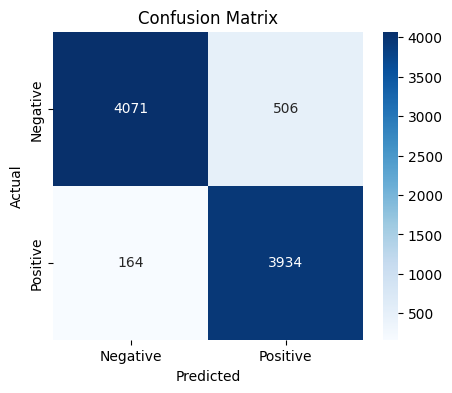

              precision    recall  f1-score   support

    Negative       0.96      0.89      0.92      4577
    Positive       0.89      0.96      0.92      4098

    accuracy                           0.92      8675
   macro avg       0.92      0.92      0.92      8675
weighted avg       0.93      0.92      0.92      8675



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

y_pred_prob = model.predict(X_test)

y_pred_labels = np.argmax(y_pred_prob, axis=1)

label_encoder = LabelEncoder()
y_test_encoded_numerical = label_encoder.fit_transform(y_test)

cm = confusion_matrix(y_test_encoded_numerical, y_pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_encoded_numerical, y_pred_labels, target_names=['Negative', 'Positive']))

In [ ]:
model.save("Twitter-Sentiment-Analysis.h5")


In [ ]:
from google.colab import files
files.download("Twitter-Sentiment-Analysis.h5")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

from google.colab import files
files.download("tokenizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment'])

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

from google.colab import files
files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>